In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
train_df = pd.read_csv("data/train.csv", low_memory=True)

In [4]:
train_df.head()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,...,0.0,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,...,0.0,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,...,0.0,0.0,0.0,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,...,0.0,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,...,0.0,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0


In [7]:
# check that all features are numerical -> yes, so we don't need encoding
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993574 entries, 0 to 1993573
Columns: 113 entries, index to fact_temperature
dtypes: float64(112), int64(1)
memory usage: 1.7 GB


In [45]:
count_nan_series = train_df.isna().sum()
nan_cols = count_nan_series[count_nan_series > 0].index.values
nan_cols

array(['cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500',
       'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_0_0',
       'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0',
       'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10', 'cmc_0_2_2_1000',
       'cmc_0_2_2_500', 'cmc_0_2_2_700', 'cmc_0_2_2_850', 'cmc_0_2_2_925',
       'cmc_0_2_3_10', 'cmc_0_2_3_1000', 'cmc_0_2_3_500', 'cmc_0_2_3_700',
       'cmc_0_2_3_850', 'cmc_0_2_3_925', 'cmc_0_3_0_0',
       'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000',
       'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925',
       'cmc_0_6_1_0', 'cmc_horizon_h', 'cmc_precipitations',
       'cmc_timedelta_s', 'wrf_t2_next', 'wrf_psfc', 'wrf_rh2',
       'wrf_wind_u', 'wrf_wind_v', 'wrf_rain', 'wrf_snow', 'wrf_graupel',
       'wrf_t2_interpolated', 'wrf_t2_grad', 'cmc_0_1_65_0_grad',
       'cmc_0_1_65_0_next', 'cmc_0_1_66_0_grad', 'cmc_0_1_66_0_next',
       'cmc_0_1_67_0_grad', 'cmc_0_1

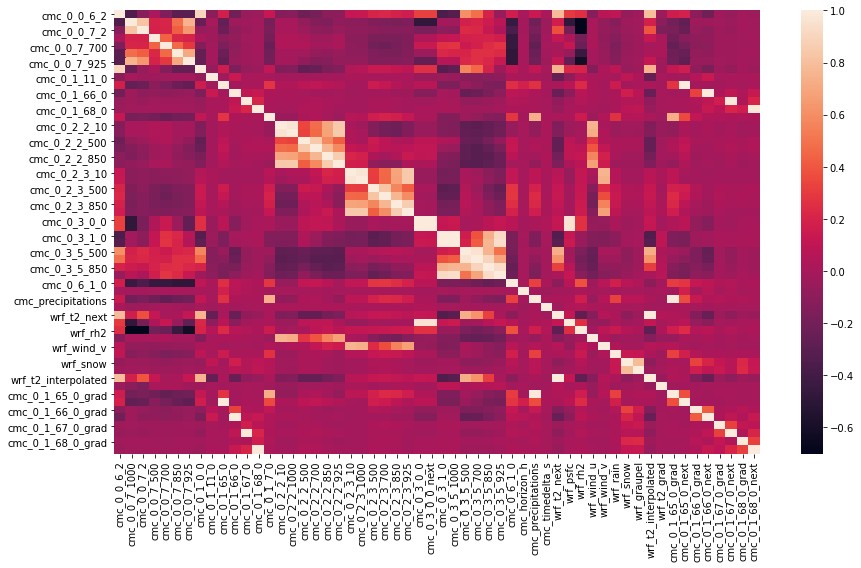

In [40]:
plt.figure(figsize = (13,8))
nan_corr_df = train_df[nan_cols].corr() 
sns.heatmap(nan_corr_df)
plt.tight_layout()
plt.show()

In [61]:
nan_corr_mat = nan_corr_df.corr().abs()
# select upper triangle of corr matrix
upper = nan_corr_mat.where(np.triu(np.ones(nan_corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))
to_drop

23


['cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_700',
 'cmc_0_2_2_925',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_700',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0_next',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_700',
 'cmc_precipitations',
 'wrf_psfc',
 'wrf_rh2',
 'wrf_wind_u',
 'wrf_wind_v',
 'wrf_graupel',
 'wrf_t2_interpolated',
 'cmc_0_1_65_0_grad',
 'cmc_0_1_65_0_next',
 'cmc_0_1_66_0_next',
 'cmc_0_1_67_0_next',
 'cmc_0_1_68_0_next']

In [60]:
upper['cmc_0_0_7_925']

cmc_0_0_6_2            0.363319
cmc_0_0_7_1000         0.959149
cmc_0_0_7_2            0.914098
cmc_0_0_7_500          0.601984
cmc_0_0_7_700          0.657595
cmc_0_0_7_850          0.927795
cmc_0_0_7_925               NaN
cmc_0_1_0_0                 NaN
cmc_0_1_11_0                NaN
cmc_0_1_65_0                NaN
cmc_0_1_66_0                NaN
cmc_0_1_67_0                NaN
cmc_0_1_68_0                NaN
cmc_0_1_7_0                 NaN
cmc_0_2_2_10                NaN
cmc_0_2_2_1000              NaN
cmc_0_2_2_500               NaN
cmc_0_2_2_700               NaN
cmc_0_2_2_850               NaN
cmc_0_2_2_925               NaN
cmc_0_2_3_10                NaN
cmc_0_2_3_1000              NaN
cmc_0_2_3_500               NaN
cmc_0_2_3_700               NaN
cmc_0_2_3_850               NaN
cmc_0_2_3_925               NaN
cmc_0_3_0_0                 NaN
cmc_0_3_0_0_next            NaN
cmc_0_3_1_0                 NaN
cmc_0_3_5_1000              NaN
cmc_0_3_5_500               NaN
cmc_0_3_

In [63]:
train_df.columns.values

array(['index', 'fact_time', 'fact_latitude', 'fact_longitude',
       'topography_bathymetry', 'sun_elevation', 'climate_temperature',
       'climate_pressure', 'cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2',
       'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925',
       'cmc_0_1_0_0', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0',
       'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_2_2_10',
       'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
       'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
       'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925',
       'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_1000',
       'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925',
       'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h',
       'cmc_precipitations', 'cmc_timedelta_s', 'gfs_2m_dewpoint',
       'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness',
       'gfs_clouds_sea', 'gfs_ho

In [68]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper
# to drop: cmc_0_2_2_1000, cmc_0_2_2_925, cmc_0_2_3_1000, cmc_0_2_3_925

,cmc_0_2_2_10,cmc_0_2_2_1000,cmc_0_2_2_500,cmc_0_2_2_700,cmc_0_2_2_850,cmc_0_2_2_925,cmc_0_2_3_10,cmc_0_2_3_1000,cmc_0_2_3_500,cmc_0_2_3_700,cmc_0_2_3_850,cmc_0_2_3_925
cmc_0_2_2_10,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_1000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_500,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_700,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_850,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_2_925,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
cmc_0_2_3_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0
cmc_0_2_3_1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
cmc_0_2_3_500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
cmc_0_2_3_700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper

In [ ]:
final_train_df = train_df.copy()
to_keep = ['fact_latitude','fact_longitude','topography_bathymery','sun_elevation', 'climate_temperature', 'climate_pressure',
         'cmc_0_0_6_2', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_1_0_0']

In [92]:
train_df_samples['fact_temperature'].to_numpy()

array([ 4., 13.,  7., ..., 19., 10., 25.])

In [94]:
train_df_samples = train_df.sample(int(0.4 * len(train_df)))

In [105]:
y = train_df_samples['fact_temperature'].to_numpy()
X = train_df_samples.fillna(0).iloc[:,:-1].to_numpy()

In [ ]:
# grid search cv

param_grid = {
            "alpha": [1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring="neg_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
